# Neural Network Model with Weather and Seasonality Features
We craft here the final model, predicting the nitrate concentration. The model is a neural network, using as features :
- weather data of the day of the Nitrate measure(temperature, maxwind, precipitation)
- the same weather data for the 60 previous days
- the day of the year (sin, cos)
The model is finally trained on all the data and exported

In [1]:
import os, re
from dotenv import dotenv_values

from sqlalchemy import create_engine, text

from datetime import date,datetime,timedelta
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

import requests

## Data Import
The data used to train the model has been prepared in the data_constitution.ipynb. The corresponding pickle file is imported

In [2]:
data = pd.read_pickle('../data/prepared_data.pkl')

## NN Model

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Normalization

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

2022-02-17 10:18:28.177532: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-17 10:18:28.177559: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
feat_cols = [
    'mean_nitrate',
    'precipitation',
    'temperature',
    'maxwind',
    'sin_doy',
    'cos_doy',
]

DELTA = 60 # 60 days of previous weather used as features

for delta in range(1,DELTA+1) :
    feat_cols += [f'precipitation_{delta}']
    feat_cols += [f'temperature_{delta}']
    feat_cols += [f'maxwind_{delta}']

In [5]:
df = data.copy()

# Retreiving Validation Data
VAL_STATION = 6045800 # 6059500
val_rows = (df['station_id'] == VAL_STATION) & (df['day'] > datetime(year=2016,month=1,day=1))

df_val = df[val_rows].copy()
df = df[df['station_id'] != VAL_STATION].copy()
X_val = df_val[feat_cols]
y_val=df_val['measure']

# Features, Target
X = df[feat_cols]
y = df['measure']

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


In [18]:
def init_model(X_train):
    
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    regl2 = regularizers.L2(0.01)
    # model better without regularizer, some features may be of less importance
    
    model = models.Sequential()
    
    model.add(normalizer)
    
    model.add( layers.Dense(200,activation='relu') )
    model.add( layers.Dropout(rate=0.3) )
    model.add( layers.Dense(100,activation='relu')) #,kernel_regularizer=regl2) )
    model.add(layers.Dropout(rate=0.4))
    
    model.add( layers.Dense(50,activation='relu')) #,kernel_regularizer=regl2) )
    model.add(layers.Dropout(rate=0.6))
    
    
    model.add(layers.Dense(1,activation='linear'))
    model.compile(loss='mse', optimizer='adam',metrics=[tf.keras.metrics.RootMeanSquaredError('rmse')])
    
    return model

model = init_model(X_train)


es = EarlyStopping(
	patience=20,
	monitor='val_loss',
	restore_best_weights=True
)

history = model.fit(
	X_train,y_train,
	epochs=2000,
	batch_size=32,
	callbacks=[es],
	validation_data=(X_test, y_test),
	verbose=0
)

val_loss_min = min(history.history['val_loss'])
print(f'{val_loss_min=}')

val_loss_min=4.587275981903076


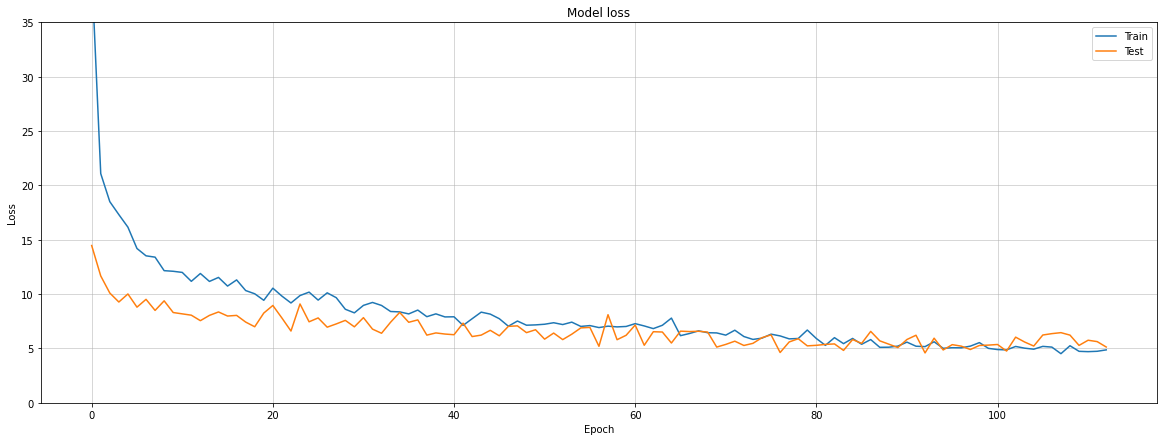

In [19]:
def plot_loss(history, title=None):
    fig = plt.figure(figsize=(20,7))
    
    # --- LOSS --- 
    ax = plt.gca()
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title('Model loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylim((0,35))
    ax.legend(['Train', 'Test'], loc='best')
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

plot_loss(history)

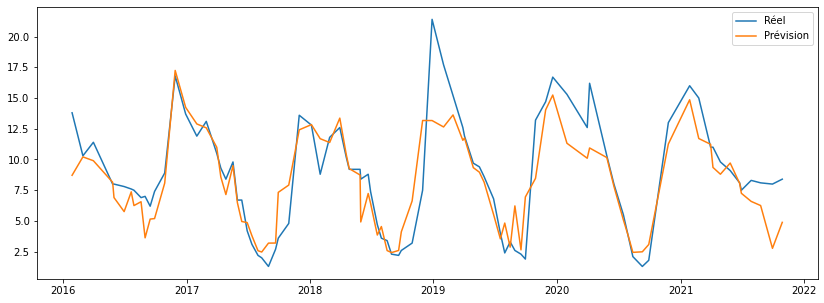

In [20]:
# Visually comparing Predicted Values and real values
# for a prediction done on unseen data
y_pred = model.predict(X_val)
df_val['prediction'] = y_pred

df_val.sort_values('day',inplace=True)

plt.figure(figsize=(14,5))
plt.plot(df_val['day'],df_val['measure'],label='Réel')
plt.plot(df_val['day'],df_val['prediction'],label='Prévision')
plt.legend()
plt.show()

##  Model Evaluation

In [9]:
from sklearn.model_selection import KFold

In [21]:
df = data.copy()

# Features, Target
X = df[feat_cols].to_numpy()
y = df['measure'].to_numpy()

# K-Fold Cross Validation model evaluation
fold_n = 1
folds_rmse = []
folds_loss = []

kfold = KFold(n_splits=10, shuffle=True)

for train, test in kfold.split(X,y):
    
    model = init_model(X[train])
    print(f'Training for fold {fold_n}...')

    history = model.fit(
        X[train],y[train],
        epochs=80,
        batch_size=32,
        verbose=0
    )
    
    scores = model.evaluate(X[test],y[test],verbose=0)
    folds_rmse.append(scores[1])
    folds_loss.append(scores[0])
    
    fold_n += 1
    
print(f'\nAverage RMSE : {np.mean(folds_rmse)}')
print(f'Average loss : {np.mean(folds_loss)}')


Training for fold 1...
Training for fold 2...
Training for fold 3...
Training for fold 4...
Training for fold 5...
Training for fold 6...
Training for fold 7...
Training for fold 8...
Training for fold 9...
Training for fold 10...

Average RMSE : 2.35228545665741
Average loss : 5.54603762626648


## Final Training and Model Export

In [11]:
df = data.copy()

X = df[feat_cols].to_numpy()
y = df['measure'].to_numpy()

model = init_model(X)
model.fit(X,y,epochs=30,batch_size=32,verbose=0)


In [12]:
model.save('../keras_model')

2022-02-17 10:19:07.302254: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../keras_model/assets
